<a href="https://colab.research.google.com/github/Wisley1/DataCon2023/blob/main/final_datacon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [76]:
#@title Installs
!pip install rdkit
!pip install klib
!pip install catboost
import pandas as pd
import numpy as np
import klib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
import re
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score

from rdkit import Chem
from rdkit.Chem import Descriptors

from sklearn.preprocessing import LabelEncoder

import joblib

In [77]:
#@title Downloads data
!gdown '1BAyBQnBBzHPzH9UUjcufA60fjn4N4v1J'
!gdown '18PcxP-yEHXwrbTIzFPHLo__6KJ09c3KH'
!gdown '1BAyBQnBBzHPzH9UUjcufA60fjn4N4v1J'
!gdown '1K4PN1aCJotOHzG8hOUYnEuDvQQKNNYdO'
!gdown '1dL0xpm0ur9k2wd9W4R6I-e25rSuMql63'

Downloading...
From: https://drive.google.com/uc?id=1BAyBQnBBzHPzH9UUjcufA60fjn4N4v1J
To: /content/drug_descriptors.csv
100% 6.26k/6.26k [00:00<00:00, 14.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=18PcxP-yEHXwrbTIzFPHLo__6KJ09c3KH
To: /content/bacterial_descriptors.csv
100% 9.99k/9.99k [00:00<00:00, 17.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1BAyBQnBBzHPzH9UUjcufA60fjn4N4v1J
To: /content/drug_descriptors.csv
100% 6.26k/6.26k [00:00<00:00, 14.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1K4PN1aCJotOHzG8hOUYnEuDvQQKNNYdO
To: /content/chosen_descriptors.txt
100% 459/459 [00:00<00:00, 1.23MB/s]
Downloading...
From: https://drive.google.com/uc?id=1dL0xpm0ur9k2wd9W4R6I-e25rSuMql63
To: /content/data.csv
100% 144k/144k [00:00<00:00, 2.45MB/s]


In [78]:
#@title Functions
def get_name_descriptors():
    with open(file='/content/chosen_descriptors.txt', mode='r') as file:
        name_descriptors = file.readlines()
        name_descriptors = "".join(name_descriptors).split('\n')[0:len(name_descriptors)]
        return name_descriptors
name_descriptors = get_name_descriptors()

def get_descriptors(mol):
    calculator = Descriptors.CalcMolDescriptors(mol)
    value_descriptros = []
    for i in range(len(name_descriptors)):
        value_descriptros.append(calculator[name_descriptors[i]])
    return dict(zip(name_descriptors, value_descriptros))


def get_data_frame(df):
    df_final = df.copy()
    descriptors_values = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        dict_descriptors = get_descriptors(mol)
        descriptors_values.append([dict_descriptors[desc] for desc in name_descriptors])
    descriptors_df = pd.DataFrame(descriptors_values, columns=name_descriptors)
    df_final = pd.concat([df_final, descriptors_df], axis=1)
    return df_final

def distribution(dt, col):
  x = str(col)
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16, 8), sharex=False, sharey=False)
  fig.suptitle(x, fontsize=20)

  ax[0].title.set_text('distribution')
  variable = dt[x].fillna(dt[x].mean())
  sns.histplot(variable, kde=True, element='step', fill=True, alpha=.5, ax=ax[0])
  des = dt[x].describe()
  ax[0].axvline(des["25%"], ls='--')
  ax[0].axvline(des["mean"], ls='--')
  ax[0].axvline(des["75%"], ls='--')
  ax[0].grid(True)
  des = round(des, 2).apply(lambda x: str(x))
  box = '\n'.join(("min: "+des["min"], "25%: "+des["25%"], "mean: "+des["mean"], "75%: "+des["75%"], "max: "+des["max"]))
  ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))

  ax[1].title.set_text('outliers')
  tmp_dtf = pd.DataFrame(dt[x])
  tmp_dtf.boxplot(column=x, ax=ax[1])
  print(plt.show())

def regr_plot(y_train, y_test, y_pred, y1_pred):
    f, ax = plt.subplots(figsize=(15, 10))
    plt.scatter(y_train, y1_pred, s=75, label='Train')
    plt.scatter(y_test, y_pred, s=75, label='Test')
    plt.plot(y_test, y_test)
    plt.xlabel('Test data', fontsize=25)
    plt.ylabel('Predicted data', fontsize=25)
    plt.legend(fontsize = 20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                44 non-null     int64  
 1   drug                      44 non-null     object 
 2   chemID                    44 non-null     object 
 3   prefered_name             44 non-null     object 
 4   smiles                    44 non-null     object 
 5   EState_VSA9               44 non-null     float64
 6   VSA_EState1               44 non-null     float64
 7   VSA_EState10              44 non-null     float64
 8   VSA_EState2               44 non-null     float64
 9   VSA_EState3               44 non-null     float64
 10  VSA_EState4               44 non-null     float64
 11  VSA_EState5               44 non-null     float64
 12  VSA_EState6               44 non-null     float64
 13  VSA_EState7               44 non-null     float64
 14  VSA_EState8 

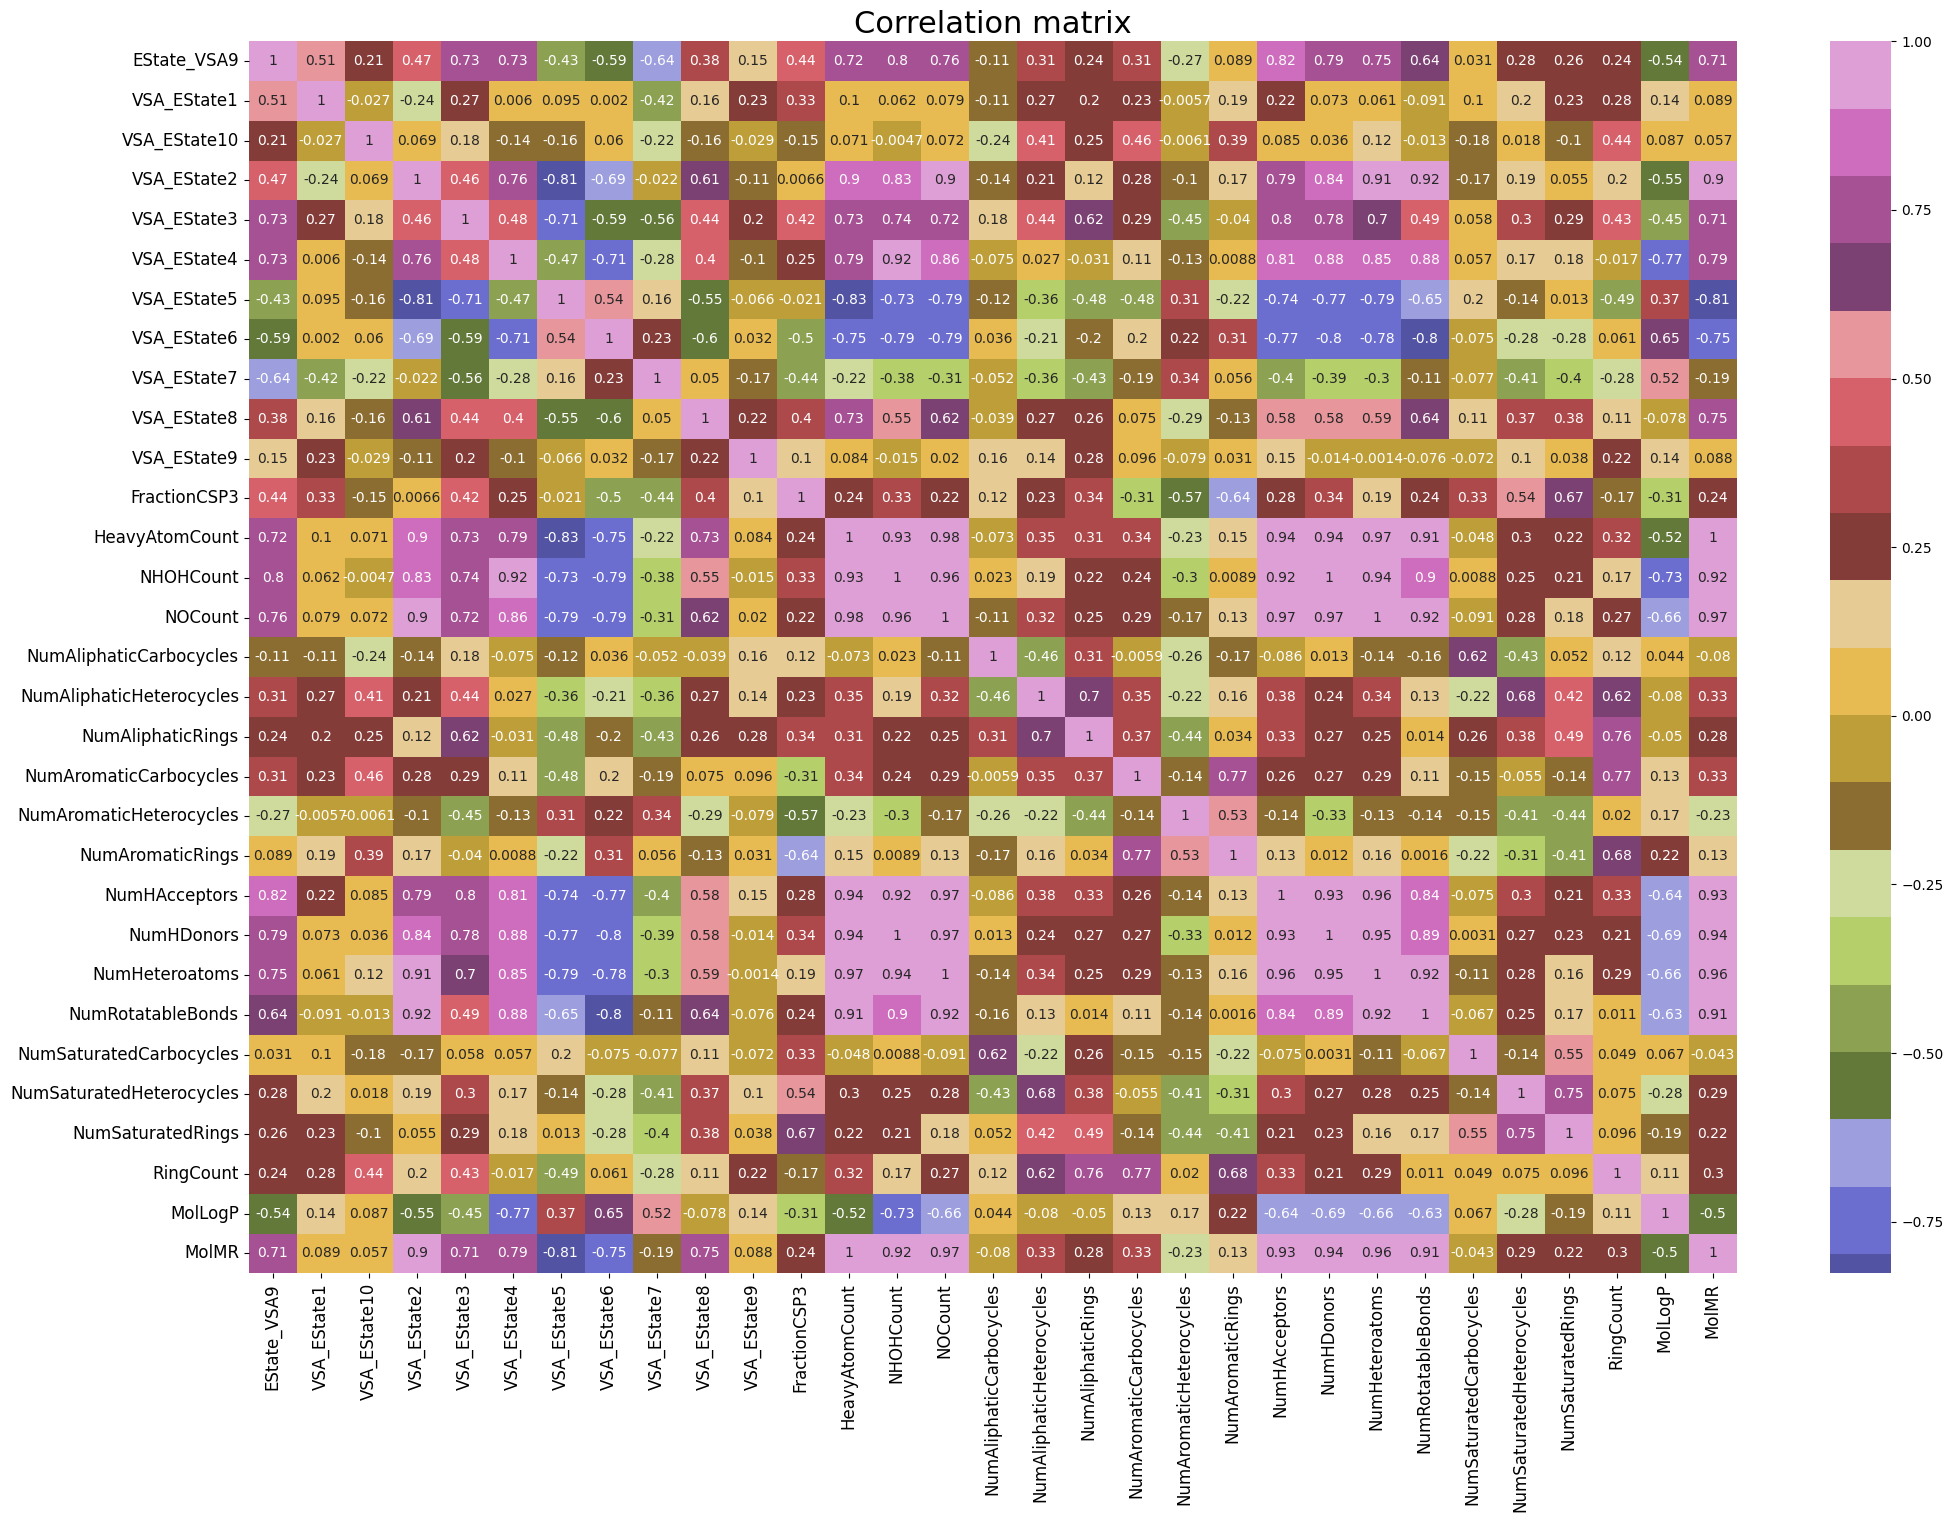

None



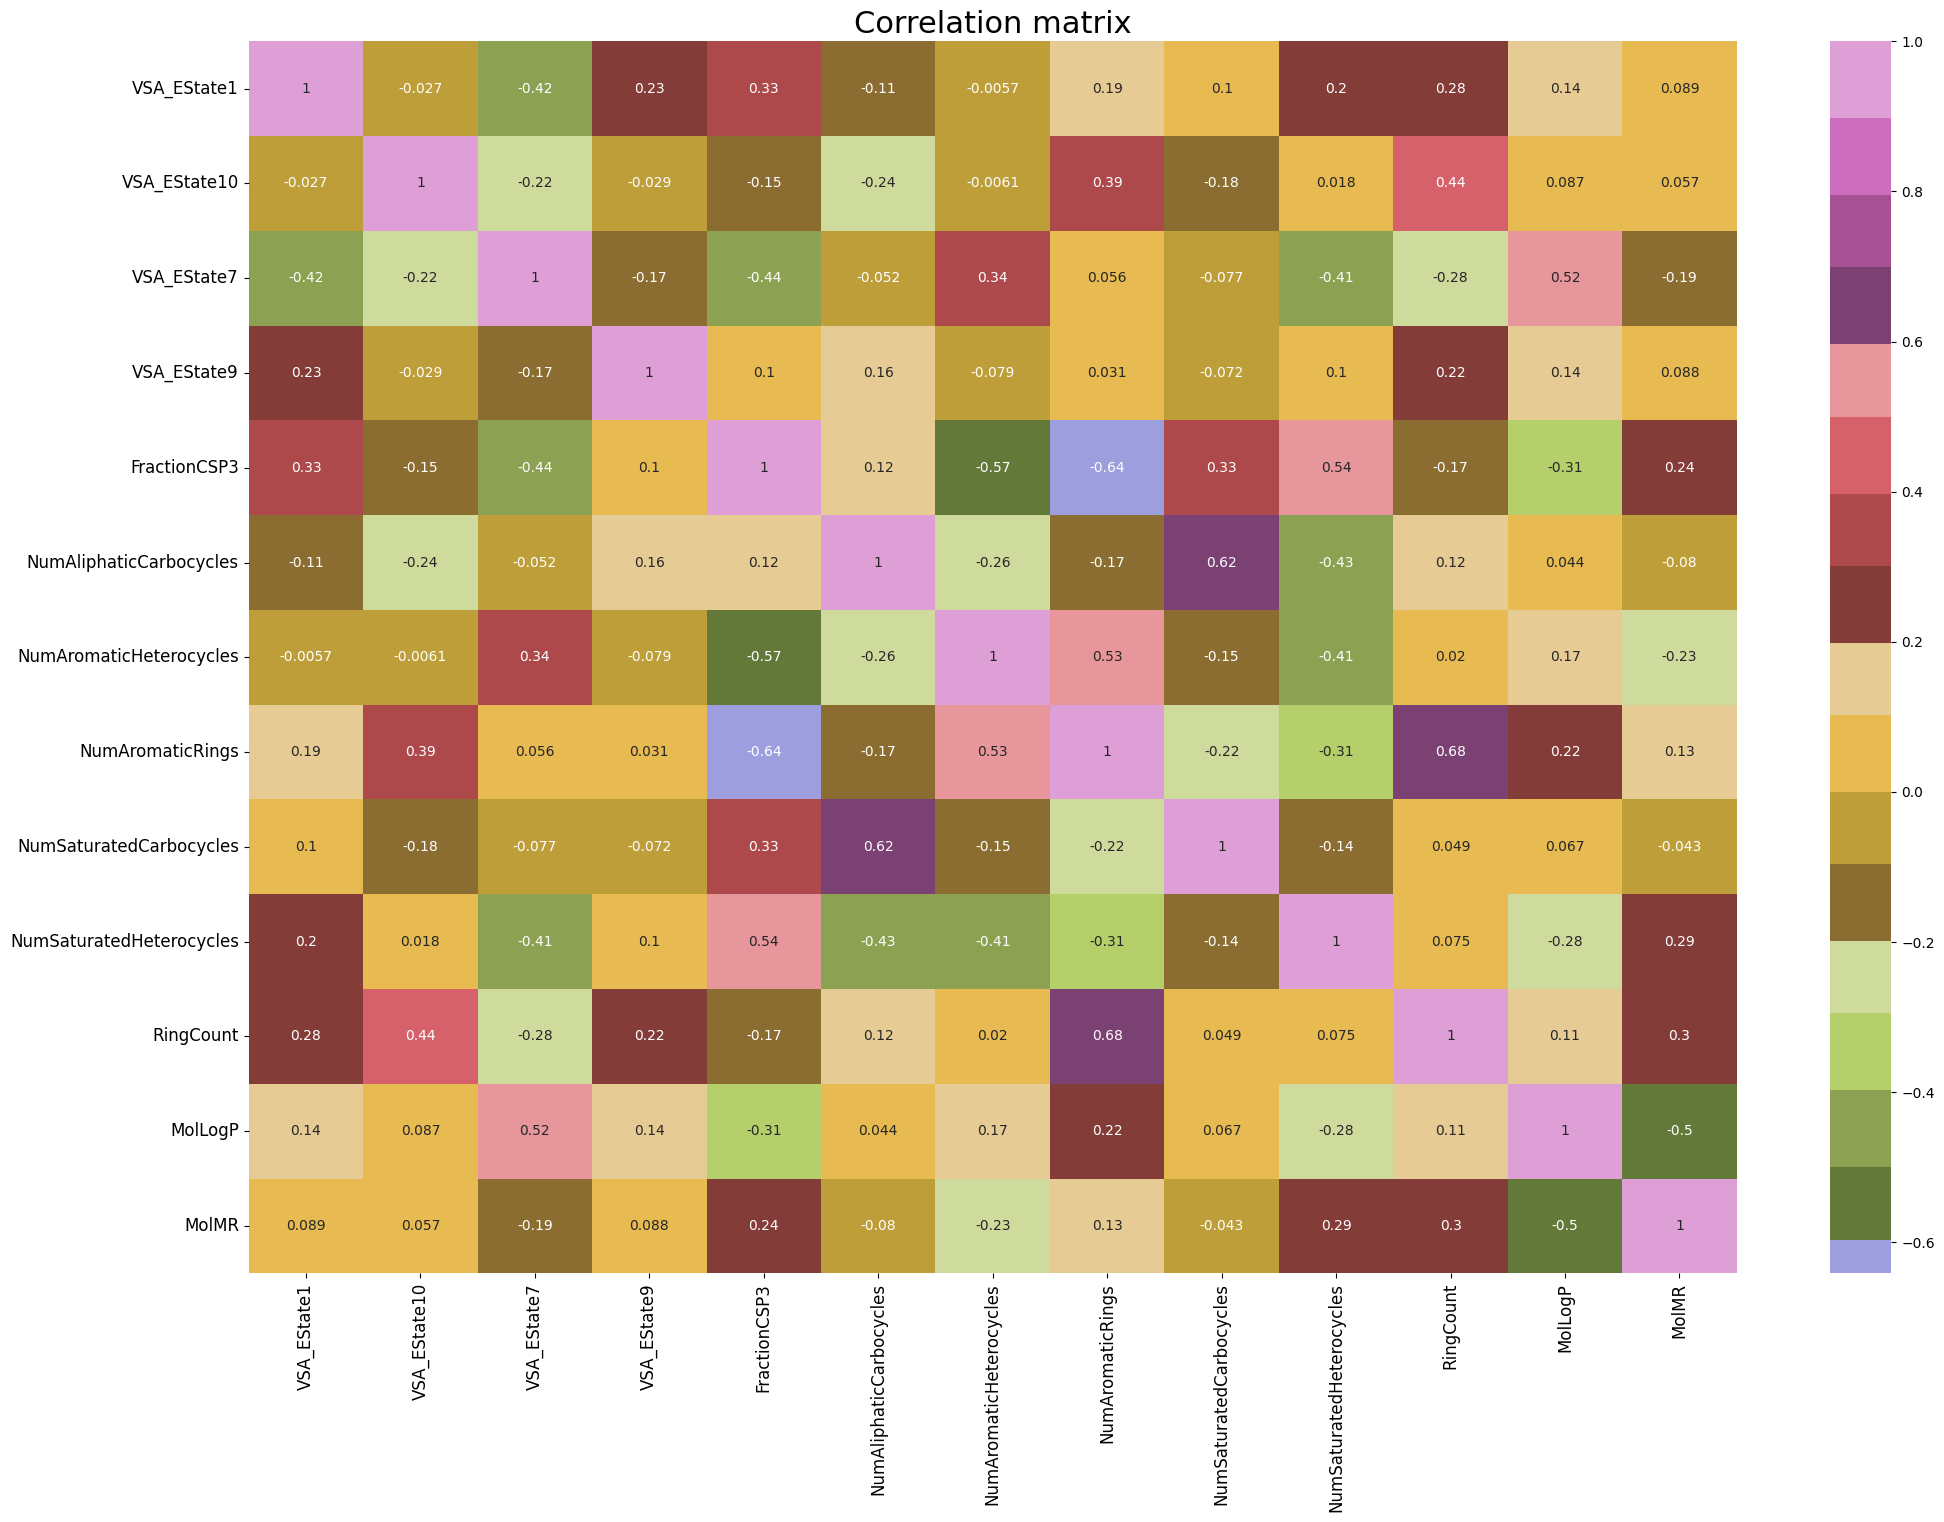

None


In [79]:
#@title Append and sort descriptors
df = pd.read_csv('/content/drug_descriptors.csv')
smiles_list = list(df['smiles'])

df_final = get_data_frame(df)
print(df_final.info())

print()

df_final = df_final.drop(columns=['Unnamed: 0'])
print(df_final.head())

print()

print(klib.missingval_plot(df_final))

print()

zero = (df_final == 0).sum()
print(zero)

print()

plt.figure(figsize=(24,16), dpi= 100)
sns.heatmap(df_final.drop(columns=['drug', 'chemID', 'prefered_name', 'smiles']).corr(),
            xticklabels=df_final.drop(columns=['drug', 'chemID', 'prefered_name', 'smiles']).corr(),
            yticklabels=df_final.drop(columns=['drug', 'chemID', 'prefered_name', 'smiles']).corr(), cmap='tab20b', center=0, annot=True)

plt.title('Correlation matrix', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
print(plt.show())

print()

df_final = df_final.drop(columns=['EState_VSA9','VSA_EState2','VSA_EState3','VSA_EState4','VSA_EState5','VSA_EState6','VSA_EState8','NHOHCount','NOCount','NumHAcceptors','NumHDonors',\
                                  'NumHeteroatoms','NumRotatableBonds','NumAliphaticHeterocycles', 'NumAliphaticRings','NumAromaticCarbocycles', 'HeavyAtomCount', 'NumSaturatedRings'])
df_final.to_csv('drug_descriptors_upd.csv', index=False)
plt.figure(figsize=(24,16), dpi= 100)
sns.heatmap(df_final.drop(columns=['drug', 'chemID', 'prefered_name', 'smiles']).corr(),
            xticklabels=df_final.drop(columns=['drug', 'chemID', 'prefered_name', 'smiles']).corr(),
            yticklabels=df_final.drop(columns=['drug', 'chemID', 'prefered_name', 'smiles']).corr(), cmap='tab20b', center=0, annot=True)

plt.title('Correlation matrix', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
print(plt.show())

Displaying only columns with missing values.
No missing values found in the dataset.
None
No missing values found in the dataset.
None
No missing values found in the dataset.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429 entries, 0 to 428
Data columns (total 44 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     429 non-null    int64  
 1   Bacteria                  429 non-null    object 
 2   NP_Synthesis              429 non-null    object 
 3   Drug                      429 non-null    object 
 4   Drug_class_drug_bank      429 non-null    object 
 5   Drug_dose                 429 non-null    float64
 6   NP_concentration          429 non-null    object 
 7   NP size_min               429 non-null    float64
 8   NP size_max               429 non-null    float64
 9   NP size_avg               429 non-null    float64
 10  shape                     429 non-null    object 
 11  

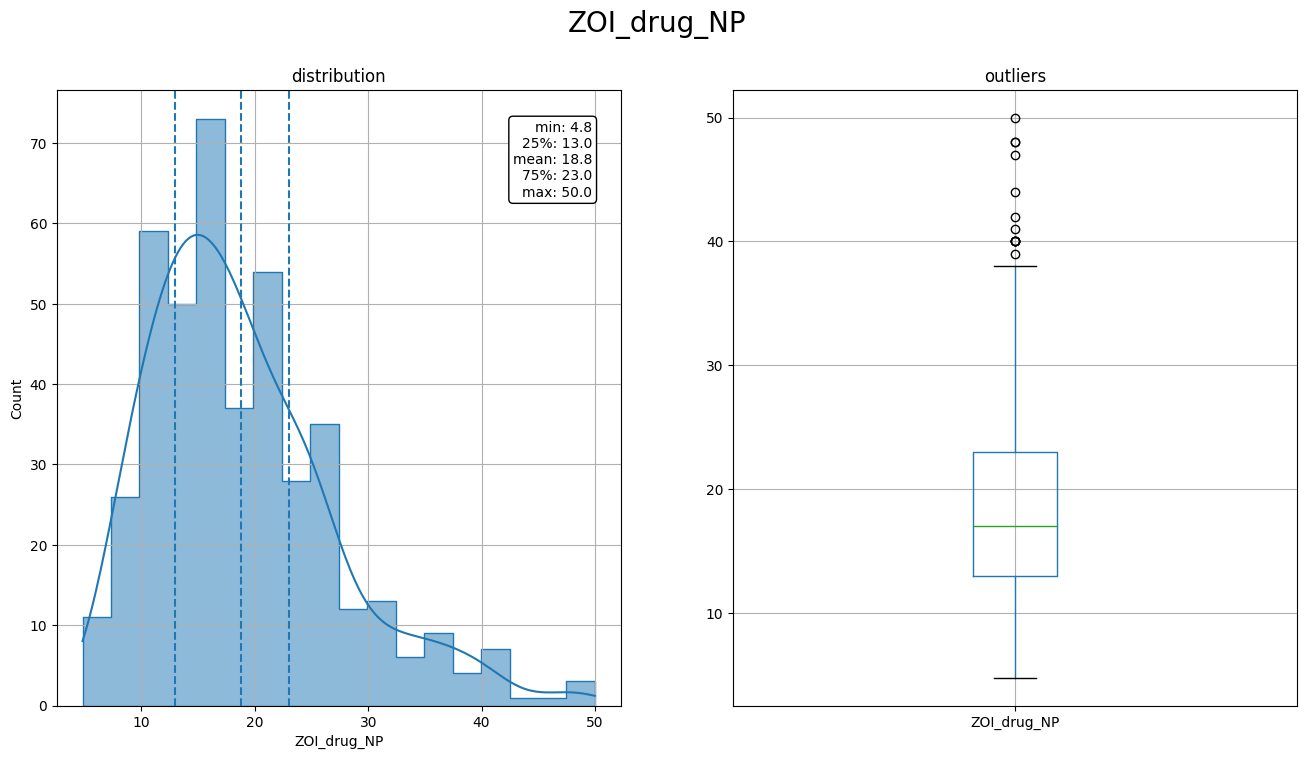

None
None


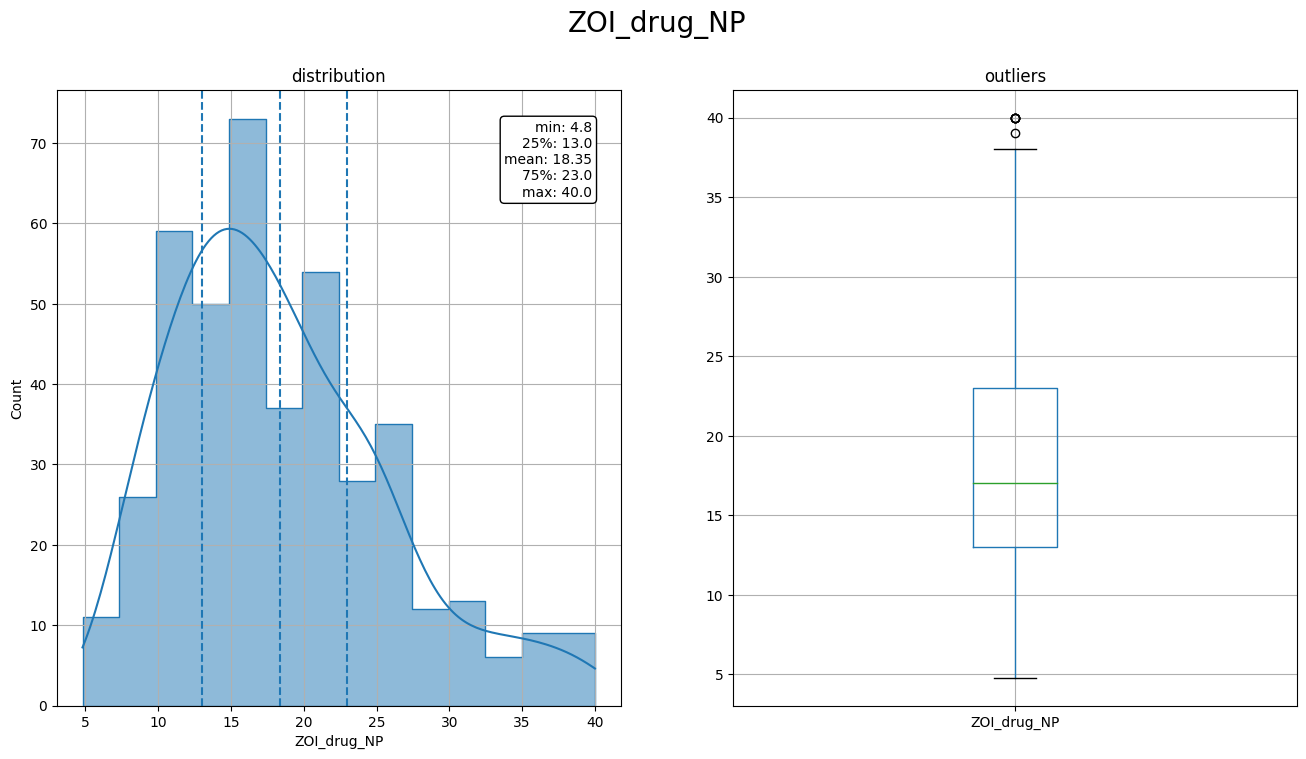

None
None


In [80]:
#@title Correct data and merge
# основной датасет (экспериментальные данные)
data = pd.read_csv('/content/data.csv')
data.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1, inplace=True)

# удалим дубликаты
data.drop_duplicates(inplace=True)

# дропнем сэмплы, где отсутствуют значения для таргетной переменной
data.dropna(subset=['ZOI_drug_NP'], inplace=True)

# преобразуем тип данных для таргетной переменной
to_replace = {'32+' : '32',
              '17+2' : '17'}

data.replace(to_replace=to_replace, inplace=True)
data['ZOI_drug_NP'] = data['ZOI_drug_NP'].astype(float)

# дропнем фичи с большим количеством пропусков
data.drop(['ZOI_NP'], axis=1, inplace=True)
data.drop(['fold_increase_in_antibacterial_activity (%)'], axis=1, inplace=True)

# предполагая важность следующих фичей, дропним сэмплы, в которых они отсутствуют
# в дальнейшем при анализе необходимо будет оценить их важность и либо оставить всё как есть,
# либо вернуть удаленные сэмплы и дропнуть сами фичи
data = data[(data['NP_concentration'].notnull()) & (data['Drug_dose'].notnull() ) & (data['ZOI_drug']).notnull()]
print(klib.missingval_plot(data, figsize=(15,10), sort=True))


# датасет с информацией по лекарствам
drug_descriptors = pd.read_csv('/content/drug_descriptors_upd.csv')
# drug_descriptors.drop(['Unnamed: 0'], axis=1, inplace=True)
drug_descriptors.rename(columns={'drug' : 'Drug'}, inplace=True)
print(klib.missingval_plot(drug_descriptors))



# датасет с информацией о бактериях
bacterial_descriptors = pd.read_csv('/content/bacterial_descriptors.csv')

# дропнем фичи с большим количеством пропусков
bacterial_descriptors.drop(['subkingdom', 'clade'], axis=1, inplace=True)

# так как в датасете содержатся не только бактерии, но и грибы, для которых параметр gram не определен
# заменим отсутствующие значения на новую категорию - undefined
bacterial_descriptors['gram'] = bacterial_descriptors['gram'].fillna('undefined')
klib.missingval_plot(drug_descriptors)



# исправим несоответсвия в названиях бактерий для корректого мерджа
to_replace = {'Acinetobacter baumanii' : 'Acinetobacter baumannii',
              'Bacillus spp.        ' : 'Bacillus sp.',
              'Enterobacter cloacae ' : 'Enterobacter cloacae',
              'Salmonella  typhi' : 'Salmonella typhi'}

data.replace(to_replace=to_replace, inplace=True)



# присоединим датасет по бактериям к основному датасету
data2 = pd.merge(data, bacterial_descriptors, how='left', on=['Bacteria'])


# присоединим датасет по лекарствам к ранее объединенному датасету
data3 = pd.merge(data2, drug_descriptors, how='left', on=['Drug'])


# оставим только средний инкубационный период и заполним пропуски при помощи KNN
data3['avg_Incub_period, h'].replace({0 : np.nan}, inplace=True)
imputer = KNNImputer(n_neighbors=2)
data3['avg_Incub_period, h'] = imputer.fit_transform(data3['avg_Incub_period, h'].values.reshape(-1, 1)).flatten()
data3.drop(['min_Incub_period, h', 'max_Incub_period, h'], axis=1, inplace=True)


# удалим оставшие несколько сэмплов с пропущенными значениями и сбросим индексацию
data3.dropna(inplace=True)
data3.reset_index(inplace=True)


print(data3.info())

data3.to_csv('db_v1.csv')

df = data3.copy()

df.drop(['index'], axis=1, inplace=True)
df['NP_concentration'] = df['NP_concentration'].apply(lambda x: x.split('/')[-1])
df['NP_concentration'] = df['NP_concentration'].astype(float)

categorical_features = df.select_dtypes(include=['object']).columns.tolist()

# Исключение из списка категориальных признаков
categorical_features = [col for col in categorical_features if col not in ['Bacteria', 'Tax_id', 'Drug', 'chemID', 'prefered_name', 'smiles']]

# Кодирование категориальных признаков
encoder = LabelEncoder()
df[categorical_features] = df[categorical_features].apply(lambda x: encoder.fit_transform(x))

print(distribution(df, 'ZOI_drug_NP'))

df = df[df['ZOI_drug_NP'] <= 40]

print(distribution(df, 'ZOI_drug_NP'))

df.drop(['Bacteria', 'Tax_id', 'Drug', 'chemID', 'prefered_name', 'smiles'], axis=1, inplace=True)


In [81]:
#@title Prep for ML
to_scale_df = df.drop(categorical_features + ['ZOI_drug_NP'], axis=1)
scaled_data = MinMaxScaler().fit_transform(to_scale_df)
scaled_df = pd.DataFrame(scaled_data, columns=to_scale_df.columns)
norm_df = scaled_df.merge(df[categorical_features + ['ZOI_drug_NP']], right_index=True, left_index=True)

x = norm_df.drop("ZOI_drug_NP", axis=1)
y = norm_df["ZOI_drug_NP"]

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=111, test_size=0.2)


forest_param = {
    "n_estimators": [20, 50, 70, 100],
    "min_samples_leaf": [3, 5, 7, 9],
    "min_samples_split": [3, 5, 7, 9],
    "max_features": ["sqrt", "log2"],
    "bootstrap": [True, False],
}

The best score: 
 0.6456863635233281
The best parameters: 
 {'bootstrap': False, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 100}
MSE: 
 15.755764370339708
R-squared: 0.7365871778963208


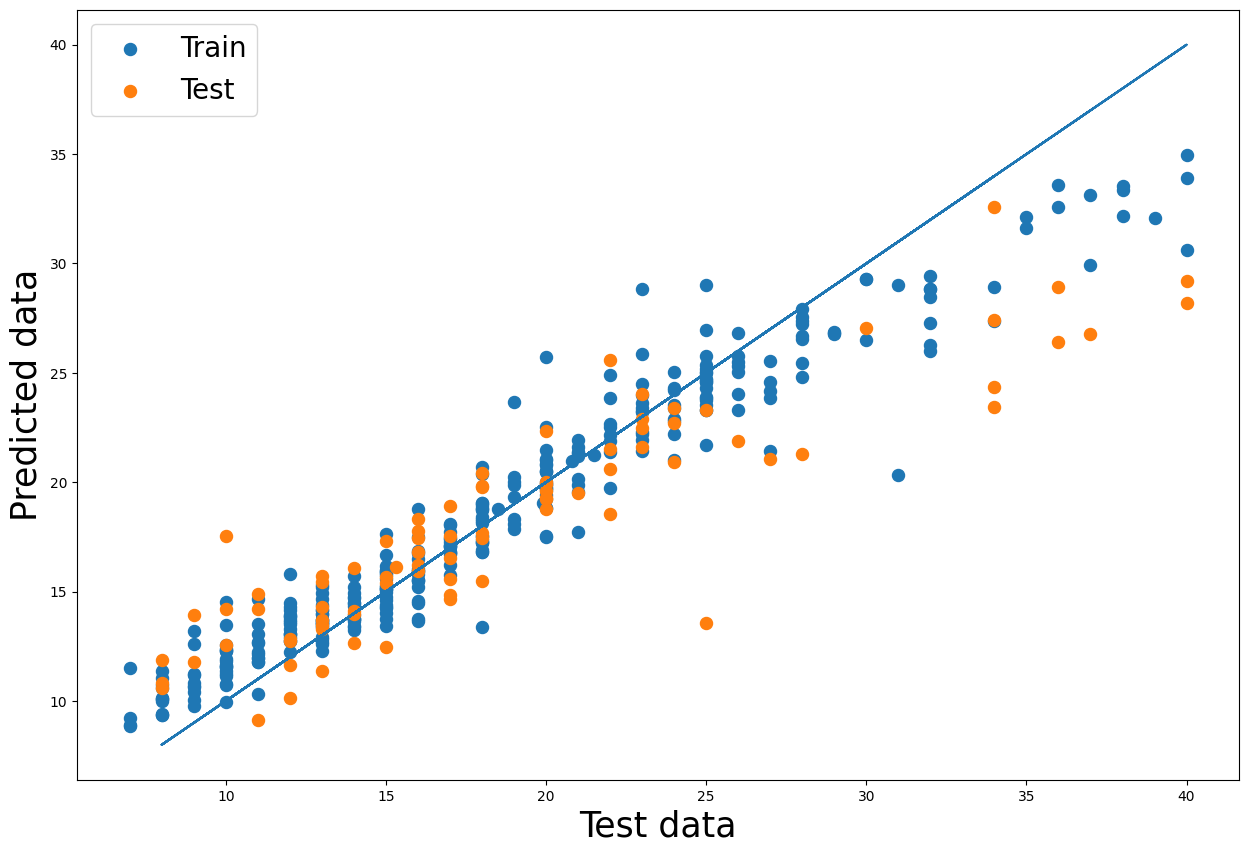

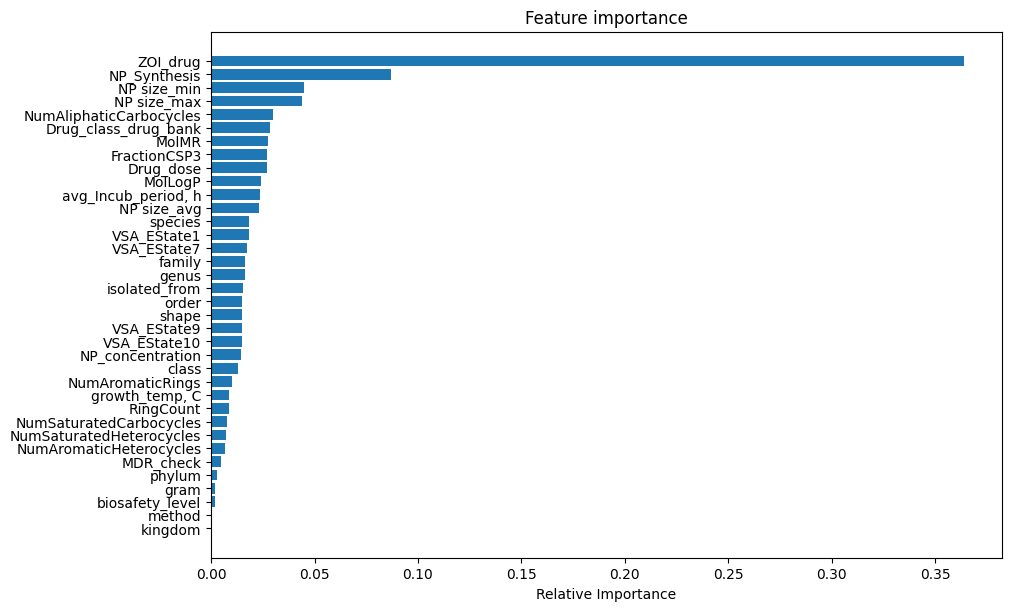

5-fold cross-validation mean score: 
 0.6377143922125283
5-fold cross-validation MSE result: 
 18.338929356819065


['model_weights.joblib']

In [82]:
#@title Models
forest_grid = GridSearchCV(RandomForestRegressor(), param_grid=forest_param, cv=5)
forest_grid.fit(x_train, y_train)
forest_best_params = forest_grid.best_params_
print("The best score: \n", forest_grid.best_score_)
print("The best parameters: \n", forest_best_params)

forest_model = RandomForestRegressor(**forest_best_params)
forest_model.fit(x_train, y_train)

# hold-out cross-validation
forest_predict = forest_model.predict(x_test)
predict = forest_model.predict(x_train)
mse = mean_squared_error(y_true=y_test, y_pred=forest_predict)

r2 = r2_score(y_test, forest_predict)
print("MSE: \n", mse)
print('R-squared:', r2)

regr_plot(y_train, y_test, forest_predict, predict)

# feature importance
features = forest_model.feature_names_in_
importance = forest_model.feature_importances_
indices = np.argsort(importance)
fig6 = plt.figure(figsize=(10, 6), constrained_layout=True)
plt.title("Feature importance")
plt.barh(range(len(indices)), importance[indices], align="center")
plt.yticks(range(len(indices)), features[indices])
plt.xlabel("Relative Importance")
plt.show()

# 5-fold cross-validation
cross_val_pred = cross_val_predict(RandomForestRegressor(**forest_best_params),
                                                          x_train, y_train, cv=5)
cross_val_score = cross_val_score(RandomForestRegressor(**forest_best_params),
                                                         x_train, y_train, cv=5)
cross_val_score = sum(cross_val_score) / len(cross_val_score)
cross_val_mse = mean_squared_error(y_true=y_train, y_pred=cross_val_pred)
print("5-fold cross-validation mean score: \n", cross_val_score)
print("5-fold cross-validation MSE result: \n", cross_val_mse)

joblib.dump(forest_model, 'model_weights.joblib')

In [83]:
#@title RandomRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
r2_train = r2_score(y_train, model.predict(x_train))

print('Mean Squared Error:', mse)
print('R-squared:', r2)
print('R-squared for train data (check overfitting):', r2_train)

Mean Squared Error: 12.340629153279789
R-squared: 0.7936831323829783
R-squared for train data (check overfitting): 0.9681142885229894


In [84]:
#@title GradientBoostingRegressor
model = GradientBoostingRegressor(n_estimators=1000, random_state=42)
model.fit(x_train, y_train)



y_pred = model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
r2_train = r2_score(y_train, model.predict(x_train))

print('Mean Squared Error:', mse)
print('R-squared:', r2)
print('R-squared for train data (check overfitting):', r2_train)


Mean Squared Error: 10.225139720822192
R-squared: 0.8290509525937949
R-squared for train data (check overfitting): 0.9996841297858956


In [85]:
#@title DecisionTreeRegressor
base_model = DecisionTreeRegressor()

bagging_model = BaggingRegressor(base_model, n_estimators=150, random_state=42)

bagging_model.fit(x_train, y_train)

y_pred = bagging_model.predict(x_test)
r2 = r2_score(y_test, y_pred)
r2_train = r2_score(y_train, model.predict(x_train))

mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)
print('R-squared:', r2)
print('R-squared for train data (check overfitting):', r2_train)


Mean Squared Error: 13.094189024096385
R-squared: 0.7810847380727944
R-squared for train data (check overfitting): 0.9996841297858956


In [88]:

#@title Применение вашего теста здесь
# Загрузка модели
loaded_model = joblib.load('model_weights.joblib')

# Применение модели к тестовой выборке
result = loaded_model.predict(x_test)
print(result)



     Drug_dose  NP_concentration  NP size_min  NP size_max  NP size_avg  \
133   1.000000          0.222222          0.2     0.070245     0.015898   
399   1.000000          0.222222          0.2     0.070245     0.015898   
284   1.000000          0.222222          0.2     0.070245     0.015898   
203   1.000000          0.222222          0.2     0.070245     0.015898   
96    1.000000          0.222222          0.2     0.070245     0.015898   
..         ...               ...          ...          ...          ...   
356   1.000000          0.222222          0.2     0.070245     0.015898   
172   0.058116          1.000000          0.0     0.228098     0.254372   
406   1.000000          0.222222          0.2     0.070245     0.015898   
52    1.000000          0.222222          0.2     0.070245     0.015898   
360   1.000000          0.222222          0.2     0.070245     0.015898   

     MDR_check  avg_Incub_period, h  growth_temp, C  biosafety_level  \
133        0.0             

TypeError: ignored